In [77]:
"""
Baseline code from the
Sparse Inversion paper
and associated code in Zenodo
repository.
"""
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from collections import Counter
from sklearn.metrics import f1_score
import torch.nn.functional as F
import time
import h5py
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
plt.rc('font',family='Times New Roman', size=12)

In [78]:
import torch

torch.cuda.is_available()

True

In [79]:
# Deep network parameters
patience = 20
epochs = 180
tra_num = 20000
val_num = 2000
part_num = 100
category = 6
batch_size = 16
num_cell = 32
learning_rate = 4e-4
threshold = 1e-4
realdata_num = 1
start_fm = 32
syn_num = part_num*category
total_num = tra_num + val_num


# Physical parameters
density = 1000

# Ablation
noise_levels = [0.02, 0.1]

In [80]:
#############################
# Define basic modules
#############################

# Standard double convolution block (used for local feature extraction)
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.ELU = nn.ELU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.ELU(self.conv1(x))
        x = self.conv2(x)
        return x

##############################################
# Graph Convolution with Multi-Head Updates
##############################################

class GraphConv(nn.Module):
    """
    Graph convolution that:
      1. Computes K-nearest neighbors based on Euclidean distance.
      2. Aggregates neighbor features via an elementwise maximum.
      3. Concatenates the original node feature with the aggregated neighbor feature.
      4. Applies multi-head linear updates.
    """
    def __init__(self, in_dim, out_dim, num_heads=4, k=8):
        super(GraphConv, self).__init__()
        self.num_heads = num_heads
        self.k = k
        assert out_dim % num_heads == 0, "out_dim must be divisible by num_heads"
        self.head_dim = out_dim // num_heads
        # Create a separate linear layer for each head.
        self.linears = nn.ModuleList([nn.Linear(2 * in_dim, self.head_dim) for _ in range(num_heads)])

    def forward(self, x):
        # x: (B, N, D)
        B, N, D = x.shape

        # Compute pairwise Euclidean distances: shape (B, N, N)
        dist = torch.cdist(x, x, p=2)
        # Mask self-distance by setting diagonal entries to infinity
        diag = torch.eye(N, device=x.device).bool().unsqueeze(0)
        dist.masked_fill_(diag, float('inf'))
        # Select effective k to avoid selecting more neighbors than available
        effective_k = self.k if self.k < N else N - 1
        # Get indices of k nearest neighbors (smallest distances)
        knn_indices = torch.topk(-dist, k=effective_k, dim=-1).indices  # shape: (B, N, effective_k)

        # Gather neighbor features using advanced indexing
        batch_indices = torch.arange(B, device=x.device).view(B, 1, 1).expand(B, N, effective_k)
        neighbors = x[batch_indices, knn_indices]  # shape: (B, N, effective_k, D)

        # Aggregate neighbors with elementwise maximum across the k dimension
        agg, _ = torch.max(neighbors, dim=2)  # shape: (B, N, D)

        # Concatenate the original feature with the aggregated neighbor feature
        concat_feat = torch.cat([x, agg], dim=-1)  # (B, N, 2*D)

        # Multi-head update: apply a separate linear projection per head and concatenate
        head_outputs = []
        for linear in self.linears:
            head_outputs.append(linear(concat_feat))  # each: (B, N, head_dim)
        out = torch.cat(head_outputs, dim=-1)  # (B, N, out_dim)
        return out

##############################################
# ViG Block: Graph-level processing with enhancement
##############################################

class ViGBlock(nn.Module):
    """
    ViG block that applies:
      - A graph convolution (with pre- and post- linear projections and nonlinear activations)
      - A feed-forward network (FFN) to further refine node features.
      
    The block follows:
         Y = (GraphConv(X * W_in)) * W_out + X
         Z = FFN(Y) + Y
    with normalization (LayerNorm) and dropout to help prevent over-smoothing.
    """
    def __init__(self, in_dim, out_dim, num_heads=4, k=8, ff_hidden_dim=None, dropout=0.1):
        super(ViGBlock, self).__init__()
        ff_hidden_dim = ff_hidden_dim or in_dim * 2
        self.proj_in = nn.Linear(in_dim, in_dim)
        self.graph_conv = GraphConv(in_dim, out_dim, num_heads=num_heads, k=k)
        self.proj_out = nn.Linear(out_dim, out_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(out_dim)
        # Feed-forward network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(out_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, out_dim)
        )
        self.norm2 = nn.LayerNorm(out_dim)

    def forward(self, x):
        # x: (B, N, D)
        x_proj = self.proj_in(x)  # project into same domain: (B, N, D)
        gc = self.graph_conv(x_proj)  # graph convolution: (B, N, out_dim)
        gc = self.proj_out(gc)
        gc = self.activation(gc)
        gc = self.dropout(gc)
        y = x + gc  # residual connection
        y = self.norm1(y)
        # FFN to further refine features
        ffn_out = self.ffn(y)
        ffn_out = self.dropout(ffn_out)
        out = y + ffn_out  # residual connection
        out = self.norm2(out)
        return out

##############################################
# ViG-based UNet Architecture (Pyramid Architecture)
##############################################

class ViGUNet(nn.Module):
    """
    This network combines CNN-based patch processing with graph neural network modules.
    
    Unified Flow Summary:
       1. Input Processing:
          - An image is divided into patches.
          - Each patch is converted into a feature vector to form matrix X.
       2. Graph Construction:
          - A graph G is built where each node represents a patch.
          - Edges are created by connecting each node to its K nearest neighbors.
       3. Graph Convolution and Multi-Head Updates:
          - Graph convolution aggregates neighbor information via a max-relative function.
          - Features are updated via a multi-head mechanism.
       4. ViG Block Enhancement:
          - A Grapher module (ViGBlock) uses pre- and post- projections, nonlinear activations, and residual connections.
          - An FFN further refines node features.
       5. Network Architectures:
          - The ViG blocks are stacked to form a UNet-like encoder-decoder (pyramid) architecture.
    
    This complete flow leverages graph neural network principles with modern network design strategies.
    """
    def __init__(self, start_fm=32, num_heads=4, ff_hidden_dim=None, dropout=0.1, k=8):
        super(ViGUNet, self).__init__()
        self.start_fm = start_fm

        # Encoder Stage 1
        self.enc1_conv = double_conv(1, start_fm)
        self.enc1_vig = ViGBlock(start_fm, start_fm, num_heads=num_heads, k=k, dropout=dropout)
        self.pool1 = nn.MaxPool2d(2)

        # Encoder Stage 2
        self.enc2_conv = double_conv(start_fm, start_fm * 2)
        self.enc2_vig = ViGBlock(start_fm * 2, start_fm * 2, num_heads=num_heads, k=k, dropout=dropout)
        self.pool2 = nn.MaxPool2d(2)

        # Encoder Stage 3
        self.enc3_conv = double_conv(start_fm * 2, start_fm * 4)
        self.enc3_vig = ViGBlock(start_fm * 4, start_fm * 4, num_heads=num_heads, k=k, dropout=dropout)
        self.pool3 = nn.MaxPool2d(2)

        # Encoder Stage 4
        self.enc4_conv = double_conv(start_fm * 4, start_fm * 8)
        self.enc4_vig = ViGBlock(start_fm * 8, start_fm * 8, num_heads=num_heads, k=k, dropout=dropout)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck_conv = double_conv(start_fm * 8, start_fm * 16)
        self.bottleneck_vig = ViGBlock(start_fm * 16, start_fm * 16, num_heads=num_heads, k=k, dropout=dropout)

        # Decoder Stage 4
        self.up4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, kernel_size=2, stride=2)
        self.dec4_conv = double_conv(start_fm * 16, start_fm * 8)
        self.dec4_vig = ViGBlock(start_fm * 8, start_fm * 8, num_heads=num_heads, k=k, dropout=dropout)

        # Decoder Stage 3
        self.up3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, kernel_size=2, stride=2)
        self.dec3_conv = double_conv(start_fm * 8, start_fm * 4)
        self.dec3_vig = ViGBlock(start_fm * 4, start_fm * 4, num_heads=num_heads, k=k, dropout=dropout)

        # Decoder Stage 2
        self.up2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, kernel_size=2, stride=2)
        self.dec2_conv = double_conv(start_fm * 4, start_fm * 2)
        self.dec2_vig = ViGBlock(start_fm * 2, start_fm * 2, num_heads=num_heads, k=k, dropout=dropout)

        # Decoder Stage 1
        self.up1 = nn.ConvTranspose2d(start_fm * 2, start_fm, kernel_size=2, stride=2)
        self.dec1_conv = double_conv(start_fm * 2, start_fm)
        self.dec1_vig = ViGBlock(start_fm, start_fm, num_heads=num_heads, k=k, dropout=dropout)

        self.final_conv = nn.Conv2d(start_fm, 16, kernel_size=1)
        self.final_bn = nn.BatchNorm2d(16)
        self.final_act = nn.Sigmoid()

    def forward(self, inputs):
        # Encoder Stage 1
        enc1 = self.enc1_conv(inputs)  # (B, start_fm, H, W)
        B, C, H, W = enc1.shape
        enc1_flat = enc1.view(B, C, H * W).permute(0, 2, 1)  # (B, N, C)
        enc1_vig = self.enc1_vig(enc1_flat)
        enc1 = enc1_vig.permute(0, 2, 1).view(B, C, H, W)
        pool1 = self.pool1(enc1)

        # Encoder Stage 2
        enc2 = self.enc2_conv(pool1)
        B, C, H, W = enc2.shape
        enc2_flat = enc2.view(B, C, H * W).permute(0, 2, 1)
        enc2_vig = self.enc2_vig(enc2_flat)
        enc2 = enc2_vig.permute(0, 2, 1).view(B, C, H, W)
        pool2 = self.pool2(enc2)

        # Encoder Stage 3
        enc3 = self.enc3_conv(pool2)
        B, C, H, W = enc3.shape
        enc3_flat = enc3.view(B, C, H * W).permute(0, 2, 1)
        enc3_vig = self.enc3_vig(enc3_flat)
        enc3 = enc3_vig.permute(0, 2, 1).view(B, C, H, W)
        pool3 = self.pool3(enc3)

        # Encoder Stage 4
        enc4 = self.enc4_conv(pool3)
        B, C, H, W = enc4.shape
        enc4_flat = enc4.view(B, C, H * W).permute(0, 2, 1)
        enc4_vig = self.enc4_vig(enc4_flat)
        enc4 = enc4_vig.permute(0, 2, 1).view(B, C, H, W)
        pool4 = self.pool4(enc4)

        # Bottleneck
        bottleneck = self.bottleneck_conv(pool4)
        B, C, H, W = bottleneck.shape
        bottleneck_flat = bottleneck.view(B, C, H * W).permute(0, 2, 1)
        bottleneck_vig = self.bottleneck_vig(bottleneck_flat)
        bottleneck = bottleneck_vig.permute(0, 2, 1).view(B, C, H, W)

        # Decoder Stage 4
        up4 = self.up4(bottleneck)
        cat4 = torch.cat([up4, enc4], dim=1)
        dec4 = self.dec4_conv(cat4)
        B, C, H, W = dec4.shape
        dec4_flat = dec4.view(B, C, H * W).permute(0, 2, 1)
        dec4_vig = self.dec4_vig(dec4_flat)
        dec4 = dec4_vig.permute(0, 2, 1).view(B, C, H, W)

        # Decoder Stage 3
        up3 = self.up3(dec4)
        cat3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.dec3_conv(cat3)
        B, C, H, W = dec3.shape
        dec3_flat = dec3.view(B, C, H * W).permute(0, 2, 1)
        dec3_vig = self.dec3_vig(dec3_flat)
        dec3 = dec3_vig.permute(0, 2, 1).view(B, C, H, W)

        # Decoder Stage 2
        up2 = self.up2(dec3)
        cat2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.dec2_conv(cat2)
        B, C, H, W = dec2.shape
        dec2_flat = dec2.view(B, C, H * W).permute(0, 2, 1)
        dec2_vig = self.dec2_vig(dec2_flat)
        dec2 = dec2_vig.permute(0, 2, 1).view(B, C, H, W)

        # Decoder Stage 1
        up1 = self.up1(dec2)
        cat1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.dec1_conv(cat1)
        B, C, H, W = dec1.shape
        dec1_flat = dec1.view(B, C, H * W).permute(0, 2, 1)
        dec1_vig = self.dec1_vig(dec1_flat)
        dec1 = dec1_vig.permute(0, 2, 1).view(B, C, H, W)

        out = self.final_conv(dec1)
        out = self.final_bn(out)
        out = self.final_act(out)
        return out


In [81]:
##############################################
# Loss Functions
##############################################
def dice(pred, target):
    smooth = 1
    num = pred.size(0)
    m1 = pred.reshape(num, -1)
    m2 = target.reshape(num, -1)
    intersection = m1 * m2
    loss = (2. * intersection.sum(1) + smooth) / ((m1 * m1).sum(1) + (m2 * m2).sum(1) + smooth)
    return loss.sum() / num

def my_loss(pre_y, tru_y):
    loss = 1 - dice(pre_y, tru_y)
    return loss

In [ ]:
# Data folders
dataFile = './data/tra&val/data{}.mat'
syn_dataFile = './data/syn/data{}.mat'

# For creating the forward response
with h5py.File(name='./G.mat', mode='r') as f:G = torch.Tensor(np.nan_to_num(f['G'][:])).T

In [ ]:
# real_dataFile = './data/real/data{}.mat'

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, Normalize

def Model(m, w):
    m = m.T
    L, W, H = m.shape
    c = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", 
         "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    x, y, z = np.indices((L, W, H))
    model = (x < 0) & (y < 0) & (z < 0)
    color = np.empty(m.shape, dtype=object)

    for i in range(L):
        for j in range(W):
            for k in range(H):
                if m[i][j][k] >= w:
                    cube = (x > i - 1) & (x <= i) & (y > j - 1) & (y <= j) & (z > k - 1) & (z <= k)
                    model = model | cube
                    color[cube] = c[int(round(10 * m[i][j][k])) - 1]

    plt_model(model, "colored_model", facecolors=color)

def plt_model(model, fname, facecolors='r'):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, projection='3d')

    ax.voxels(model, facecolors=facecolors, edgecolors='w', linewidth=0.5)

    plt.xticks(np.arange(0, 33, 1), (
        '0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800',
        ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    ax.set_xlabel('Easting (m)', labelpad=1)
    plt.yticks(np.arange(0, 33, 1), (
        '0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800',
        ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    ax.set_ylabel('Northing (m)', labelpad=0)
    ax.set_zticks(np.arange(0, 17, 1))
    ax.set_zticklabels(['0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800'])
    ax.set_zlabel('Depth (m)', labelpad=-5)
    ax.invert_zaxis()
    ax.xaxis.set_tick_params(pad=-2)
    ax.yaxis.set_tick_params(pad=-2)
    ax.zaxis.set_tick_params(pad=0)

    # --- Add colorbar on right side ---
    cbar_colors = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F",
                   "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    cmap = ListedColormap(cbar_colors)
    norm = Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.1)
    # cbar.set_label('Normalized Density')

    plt.savefig(f'{fname}.png', dpi=300)
    plt.show()



def plt_m(y, color='b'):
    x = range(1, len(y) + 1)
    plt.xlim(-100, 16500)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 16500, step=1024), fontsize=4)
    for i in range(len(y)):
        if y[i] == 1:
            plt.scatter(x[i], y[i], linewidths=0.001)
    plt.plot(x, y, linewidth=0.8, color=color, linestyle=":")
    plt.savefig("2.png", dpi=300)



def plt_g(g, my_levels):
    color = ('#00008F', '#0030FF', '#10FFEF', '#DFFF20', '#FF5000', '#800000')
    cmap = colors.ListedColormap(color)
    g = np.where(g > 0, g, 0)
    cs = plt.contourf(g, my_levels, cmap=cmap)
    plt.contour(cs, colors='k', linewidths=0.7)
    fig.colorbar(cs)
    plt.xticks(np.arange(0, 32, 7.75), ('0', '400', '800', '1200', '1600'))
    plt.xlabel('Easting (m)')
    plt.yticks(np.arange(0, 32, 7.75), ('0', '400', '800', '1200', '1600'))
    plt.ylabel('Northing (m)')
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    plt.savefig("3.png", dpi=300)


def colorma():
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00",
             "#E10000"]
    

    return colors.ListedColormap(cdict, 'indexed')

def plot_xoy(model, index):
    print(f"For index: {index} (Depth: {index * 50} m)")
    ax = plt.gca()
    model = np.around(model, decimals=1)
    plt.imshow(model[index], cmap=colorma())
    ax.invert_yaxis()

    # Tick labels
    plt.xticks(np.arange(-0.5, 32.5, 1), (
        '0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800',
        ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    plt.xlabel('Easting (m)')

    plt.yticks(np.arange(-0.5, 32.5, 1), (
        '0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800',
        ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    plt.ylabel('Northing (m)')

    plt.grid()
    plt.colorbar(shrink=1, aspect=30)


(20000, 1, 32, 32) :: (20000, 16, 32, 32)
(2000, 1, 32, 32) :: (2000, 16, 32, 32)
(600, 1, 32, 32) :: (600, 16, 32, 32)


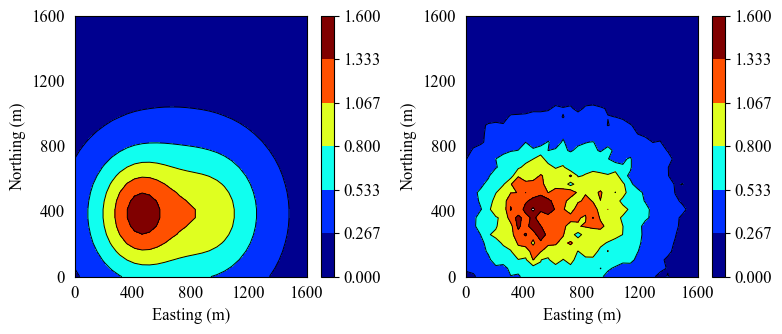

In [84]:
x = []
y = []
for i in range(total_num):
    data = h5py.File(dataFile.format(i), 'r')
    m = data['m'][0] / density
    d = data['d'][0]
    d = np.nan_to_num(d)
    x.append(d.reshape(1, num_cell, num_cell))
    y.append(m.reshape(16, num_cell, num_cell))

syn_x = []
syn_y = []
for i in range(syn_num):
    data = h5py.File(syn_dataFile.format(i), 'r')
    m = data['m'][0] / density
    d = data['d'][0]
    d = np.nan_to_num(d)
    syn_x.append(d.reshape(1, num_cell, num_cell))
    syn_y.append(m.reshape(16, num_cell, num_cell))

tra_x = x[:tra_num]
tra_y = y[:tra_num]
val_x = x[-val_num:]
val_y = y[-val_num:]


d = syn_x[400]  # Plot sample
noise_d = d + np.array(noise_levels[1]*max(d))*(np.random.normal(0, 1, d.shape))
noise_d = np.where(noise_d > 0, noise_d, 0)

fig = plt.figure(figsize=(8, 3.5))
my_levels = np.linspace(0., 1.6, 7)
plt.subplot(121)
plt_g(d[0], my_levels)

plt.subplot(122)
plt_g(noise_d[0], my_levels)
plt.tight_layout()
plt.savefig("5.png", dpi=300)

print(np.shape(tra_x), "::", np.shape(tra_y))
print(np.shape(val_x), "::", np.shape(val_y))
print(np.shape(syn_x), "::", np.shape(syn_y))

tra_idxs = list(range(len(tra_x)))
val_idxs = list(range(len(val_x)))
# np.random.shuffle(tra_idxs)
# np.random.shuffle(val_idxs)
syn_idxs = list(range(len(syn_x)))

In [85]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, train=True, masks=None):
        self.train = train
        self.images = images
        if self.train:
            self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)


tra = Dataset(np.array(tra_x).astype(np.float32)[tra_idxs], train=True,
              masks=np.array(tra_y).astype(np.float32)[tra_idxs])
val = Dataset(np.array(val_x).astype(np.float32)[val_idxs], train=True,
              masks=np.array(val_y).astype(np.float32)[val_idxs])
syn = Dataset(np.array(syn_x).astype(np.float32)[syn_idxs], train=True,
              masks=np.array(syn_y).astype(np.float32)[syn_idxs])

tra_loader = torch.utils.data.DataLoader(dataset=tra, batch_size=batch_size, shuffle=False, pin_memory=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, shuffle=False, pin_memory=False)
syn_loader = torch.utils.data.DataLoader(dataset=syn, batch_size=batch_size, shuffle=False, pin_memory=False)

In [86]:
# Initialize the ViG-based UNet model
model = ViGUNet(start_fm=32, num_heads=4, dropout=0.3, k=8)
model.cuda()

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Summarize the model with a sample input size (1, 32, 32)
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
               ELU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
       double_conv-4           [-1, 32, 32, 32]               0
            Linear-5             [-1, 1024, 32]           1,056
            Linear-6              [-1, 1024, 8]             520
            Linear-7              [-1, 1024, 8]             520
            Linear-8              [-1, 1024, 8]             520
            Linear-9              [-1, 1024, 8]             520
        GraphConv-10             [-1, 1024, 32]               0
           Linear-11             [-1, 1024, 32]           1,056
             ReLU-12             [-1, 1024, 32]               0
          Dropout-13             [-1, 1024, 32]               0
        LayerNorm-14             [-1, 1

In [87]:
import time
import torch
from torch.autograd import Variable

mean_tra_losses = []
mean_val_losses = []
mean_syn_losses = []
val_data = []
syn_data = []

start = time.time()
epoch = 0
while epoch <= epochs:
    tra_losses = []
    val_losses = []
    syn_losses = []
    model.train()
    
    # Training loop
    for images, masks in tra_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        optimizer.zero_grad()
        outputs = model(images)
        loss = my_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        tra_losses.append(loss.data)

    model.eval()

    # Validation loop
    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        with torch.no_grad():
            outputs = model(images)
            val_loss = my_loss(outputs, masks)
            val_losses.append(val_loss.data)
            if (epoch > patience and abs(mean_val_losses[-patience] - mean_val_losses[-1]) < threshold) or epoch == epochs:
                val_data.extend([[outputs, masks, images]])

    # Synthesis loop
    for images, masks in syn_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        with torch.no_grad():
            outputs = model(images)
            syn_loss = my_loss(outputs, masks)
            syn_losses.append(syn_loss.data)
            if (epoch > patience and abs(mean_val_losses[-patience] - mean_val_losses[-1]) < threshold) or epoch == epochs:
                syn_data.extend([[outputs, masks, images]])

   
    # Save model
    torch.save(model.state_dict(), 'epoch_model_vignn.pth')  # Save at the end of every epoch
    print(f"Model saved at the end of epoch {epoch}.")
    
    # Update losses and print progress
    epoch += 1
    mean_tra_losses.append(torch.mean(torch.stack(tra_losses)))
    mean_val_losses.append(torch.mean(torch.stack(val_losses)))
    mean_syn_losses.append(torch.mean(torch.stack(syn_losses)))
    print(f'Epoch: {epoch}. Tra Loss: {torch.mean(torch.stack(tra_losses)):.4f}. Val Loss: {torch.mean(torch.stack(val_losses)):.4f}. Syn Loss: {torch.mean(torch.stack(syn_losses)):.4f}')

end = time.time()
run_time = end - start
print(f"Training completed in {run_time:.2f} seconds.")





Model saved at the end of epoch 0.
Epoch: 1. Tra Loss: 0.7983. Val Loss: 0.7338. Syn Loss: 0.7109
Model saved at the end of epoch 1.
Epoch: 2. Tra Loss: 0.6681. Val Loss: 0.5605. Syn Loss: 0.5330
Model saved at the end of epoch 2.
Epoch: 3. Tra Loss: 0.5411. Val Loss: 0.5035. Syn Loss: 0.4436
Model saved at the end of epoch 3.
Epoch: 4. Tra Loss: 0.4320. Val Loss: 0.3863. Syn Loss: 0.3190
Model saved at the end of epoch 4.
Epoch: 5. Tra Loss: 0.3582. Val Loss: 0.3314. Syn Loss: 0.2670
Model saved at the end of epoch 5.
Epoch: 6. Tra Loss: 0.3187. Val Loss: 0.3013. Syn Loss: 0.2600
Model saved at the end of epoch 6.
Epoch: 7. Tra Loss: 0.2946. Val Loss: 0.2858. Syn Loss: 0.2244
Model saved at the end of epoch 7.
Epoch: 8. Tra Loss: 0.2793. Val Loss: 0.2685. Syn Loss: 0.2025
Model saved at the end of epoch 8.
Epoch: 9. Tra Loss: 0.2681. Val Loss: 0.2611. Syn Loss: 0.1910
Model saved at the end of epoch 9.
Epoch: 10. Tra Loss: 0.2600. Val Loss: 0.2495. Syn Loss: 0.1788
Model saved at the 

In [88]:
model_File = './epoch_model_vignn.pth'

In [89]:
# Load the model for evaluation
val_data = []
syn_data = []
model.load_state_dict(torch.load(model_File),strict=False)
model.eval()
for images, masks in val_loader:
    with torch.no_grad():
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        val_data.extend([[outputs, masks, images]])

for images, masks in syn_loader:
    with torch.no_grad():
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        syn_data.extend([[outputs, masks, images]])

In [90]:
# val_data = np.array(val_data)
val_truth = []
val_predict = []
val_truth_d = []
for p, q in enumerate(val_data):
    for i, j in enumerate(q[1]):
        val_truth.append(j.reshape(1, 16384)[0].cpu().numpy())
    for i, j in enumerate(q[0]):
        val_predict.append(j.reshape(1, 16384)[0].cpu().numpy())
    for i, j in enumerate(q[2]):
        val_truth_d.append(j.reshape(1, 1024)[0].cpu().numpy())

# syn_data = np.array(syn_data)
syn_truth = []
syn_predict = []
syn_truth_d = []
for p, q in enumerate(syn_data):
    for i, j in enumerate(q[1]):
        syn_truth.append(j.reshape(1, 16384)[0].cpu().numpy())
    for i, j in enumerate(q[0]):
        syn_predict.append(j.reshape(1, 16384)[0].cpu().numpy())
    for i, j in enumerate(q[2]):
        syn_truth_d.append(j.reshape(1, 1024)[0].cpu().numpy())

In [91]:
print(val_truth[0].shape)
print(val_predict[0].shape)
print(val_truth_d[0].shape)

print(syn_truth[0].shape)
print(syn_predict[0].shape)
print(syn_truth_d[0].shape)

(16384,)
(16384,)
(1024,)
(16384,)
(16384,)
(1024,)


In [92]:
val_rel = []
val_R_2 = []
syn_rel = []
syn_R_2 = []
for i in range(len(val_x)):
    val_rel.append(np.linalg.norm(np.array(val_predict[i]) - np.array(val_truth[i]), 2)/np.linalg.norm(np.array(val_truth[i]), 2))
    tru_d = val_truth_d[i].reshape(1024, 1)
    pre_d = np.asmatrix(G)*np.asmatrix(density*val_predict[i].reshape(16384, 1))
    val_R_2.append(1- np.sum(np.power(tru_d - pre_d, 2))/np.sum(np.power(tru_d - np.mean(tru_d), 2)))

E = [np.array(val_rel).mean()]
R_2 = [np.array(val_R_2).mean()]

for i in range(len(syn_x)):
    syn_rel.append(np.linalg.norm(np.array(syn_predict[i]) - np.array(syn_truth[i]), 2)/np.linalg.norm(np.array(syn_truth[i]), 2))
    tru_d = syn_truth_d[i].reshape(1024, 1)
    pre_d = np.asmatrix(G)*np.asmatrix(density*syn_predict[i].reshape(16384, 1))
    syn_R_2.append(1 - np.sum(np.power(tru_d - pre_d, 2))/np.sum(np.power(tru_d - np.mean(tru_d), 2)))

for i in range(category):
    E.append(np.array(syn_rel)[part_num*i: part_num*(i+1)].mean())
    R_2.append(np.array(syn_R_2)[part_num*i: part_num*(i+1)].mean())

In [93]:
R_2

[0.9493444714655489,
 0.9882743511133595,
 0.9759503571840469,
 0.9941907256410922,
 0.9957199012886849,
 0.9757881334668491,
 0.9818586809886619]

In [94]:
E

[0.62107676,
 0.34817582,
 0.42081055,
 0.5918148,
 0.5341699,
 0.3938236,
 0.5165317]